In [1]:
# подключаем библиотеки

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path

import keras
from keras.preprocessing.image import DirectoryIterator, ImageDataGenerator

In [2]:
# Памятка как должны располагаться данные
# Папки Training и Test (принцип у них одинаковый)
# В папке Training, например, лежат папки классов (Apple, Orange, Banana и т.д.)
# Название папки - это название класса
# Внутри папки классов уже лежат фотки с произвольным названием

train = DirectoryIterator('./images/Training', ImageDataGenerator(), target_size=(224, 224), color_mode='rgb')
test = DirectoryIterator('./images/Test', ImageDataGenerator(), target_size=(224, 224), color_mode='rgb')

Found 5021 images belonging to 10 classes.
Found 1685 images belonging to 10 classes.


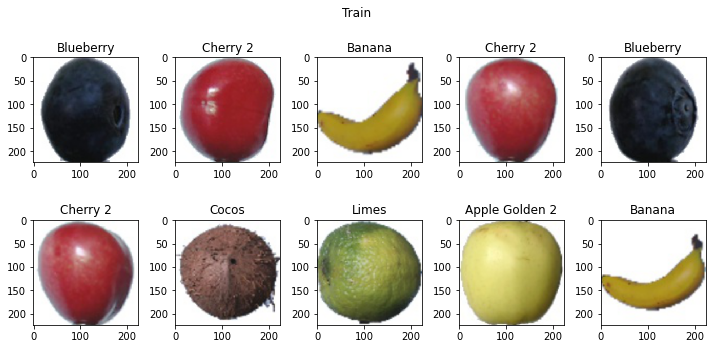

In [3]:
# отображаем тренировочные данные

plt.figure(figsize=(10, 5))
plt.suptitle('Train')
cls_ = { v: k for k, v in train.class_indices.items()}
for idx, img in enumerate(train[0][0][:10]):
    ax = plt.subplot(2, 5, idx + 1)
    plt.imshow(img.astype('int'))
    ax.set_title(cls_[train[0][1][idx].argmax()])
plt.tight_layout()

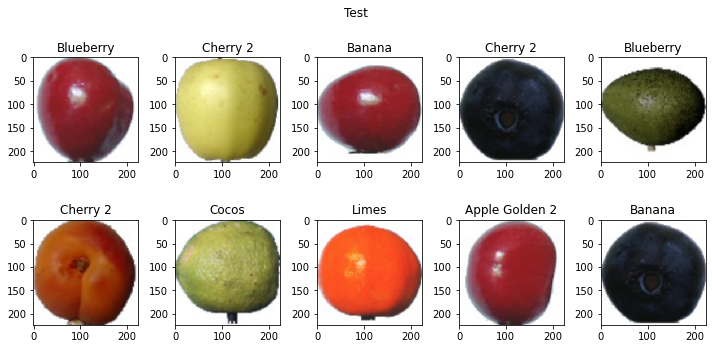

In [4]:
# Отображаем тестовые данные

plt.figure(figsize=(10, 5))
plt.suptitle('Test')
cls_ = { v: k for k, v in train.class_indices.items()}
for idx, img in enumerate(test[0][0][:10]):
    ax = plt.subplot(2, 5, idx + 1)
    plt.imshow(img.astype('int'))
    ax.set_title(cls_[train[0][1][idx].argmax()])
plt.tight_layout()

In [13]:
# Строка отвечает за подключение сущности Sequential которая реализует саму нейронную сеть
from keras.models import Sequential

# Строка отвечает за подключение сущности Dense которая реализует простой полносвязный слой сети (FFN)
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Тут мы подключаем алгоритмы тренировки Адам и алгоритм обратного распостранения ошибки(RMSprop)
from keras.optimizers import Adam, RMSprop

# Подключаем фукцию подсчета ошибки сети (кросэтропися для данных представленных в виде категорий)
from keras.losses import categorical_crossentropy, binary_crossentropy

# Подключаем фукцию подсчета метрики сети (точность попадания в категорию)
from keras.metrics import categorical_accuracy, binary_accuracy

# библиотека дополнительных возможностей (действий) при обучении сети
from keras import callbacks


def make_nn():
    model = Sequential()

    # Этот слой создает ядро свертки, которое сворачивается со входом слоя для создания тензора выходных данных
    # первое число - filters. Целое число, размерность выходного пространства (т.е.количество выходных фильтров в свертке).
    # Фильтр свертки вычеркивает элементы изображения, то есть пытается учиться на изображении. Он вычисляет скалярное произведение между значением фильтра и значениями пикселей изображения, чтобы сформировать сверточный слой.
    # Чем больше количество фильтров, тем больше функций изучает наша модель.
    # второе число - kernel_size. Целое число или кортеж/список из 2 целых чисел, задающий высоту и ширину окна двумерной свертки. Может быть одним целым числом, чтобы указать одно и то же значение для всех пространственных измерений.
    # Грубым языком, берем картинку, разбиваем ее на 8 вариаций. По картинке ездит квадратик 3х3 пикселя и делает магию.
    model.add(Conv2D(8, 3, input_shape=(train.image_shape)))

    # Сжатие картинки (размер сжатия (но это не значит, что в два раза, это рамер матрицы))
    # ездит по картинке и сжимает
    model.add(MaxPool2D(2))

    model.add(Conv2D(16, 3))
    model.add(MaxPool2D(2))

    # Выравнивает входные данные. Из матрицы делает вектор (раскладывает в линию)
    model.add(Flatten())

    # слой сети из 100 нейронов
    model.add(Dense(100, activation='relu'))

    model.add(Dense(train.num_classes, activation='softmax'))

    # алгоритм обучения Адам
    model.compile(Adam(), categorical_crossentropy, metrics=['acc'])
    
    return model


# создадим функцию создания о очистки каталога контрольных точек
# указываем шаблон имени фала контрольной точки
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{acc:.2f}_val_acc-{val_acc:.2f}.hdf5'

def make_save_points(name='save_points', file_name=file_name):
    # выбираем катагол
    checkpoints_dir = Path('./').joinpath('save_points_lb5')
    print(f'Текущий каталог с контрольными точками {checkpoints_dir.absolute()}')
    # Создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # Удаляем все из каталога
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляем файл {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

In [16]:
model = make_nn()

history = model.fit(
    train, 
    validation_data=test, 
    epochs=10, 
    verbose=1, 
    batch_size=1,
    callbacks=[
        callbacks.History(),
        
        # Callback сохранений состояний сети
        callbacks.ModelCheckpoint(
            # Указываем путь для сохранения и формат имен файлов
            make_save_points(file_name=file_name),
            # Указываем какое значение отслеживать
            monitor='val_acc',
            # Указываем, что сохранять надо только лучшие результаты
            save_best_only=True,
            # Говорим как часто проверять, что текущий результат лучше предидущего (в эпохах)
            period=2,
            # Указываем сторону лучших значений
            mode='max'
        )
    ]
)

print('Обучение закончено')
# val_acc - это точность попаданий (угадал 65 из 100. точность 0.65 (порог 0.5)) больше - лучше
# val_loss - это расстояние между прогнозом и действительным значением. меньше - лучше

Текущий каталог с контрольными точками C:\Users\artem\new_machine\save_points_lb5
Epoch 1/10
157/157 [==============================] - 28s 175ms/step - loss: 166.1434 - acc: 0.8733 - val_loss: 40.4411 - val_acc: 0.9430
Epoch 2/10
157/157 [==============================] - 28s 178ms/step - loss: 0.1366 - acc: 0.9970 - val_loss: 50.6982 - val_acc: 0.8866
Epoch 3/10
157/157 [==============================] - 28s 177ms/step - loss: 1.9071 - acc: 0.9861 - val_loss: 30.0103 - val_acc: 0.9021
Epoch 4/10
157/157 [==============================] - 28s 176ms/step - loss: 0.1914 - acc: 0.9966 - val_loss: 34.3132 - val_acc: 0.9300
Epoch 5/10
157/157 [==============================] - 28s 180ms/step - loss: 0.0878 - acc: 0.9990 - val_loss: 27.6564 - val_acc: 0.9401
Epoch 6/10
157/157 [==============================] - 28s 181ms/step - loss: 3.6631e-06 - acc: 1.0000 - val_loss: 27.3592 - val_acc: 0.9430
Epoch 7/10
157/157 [==============================] - 28s 179ms/step - loss: 0.0000e+00 - acc: 1

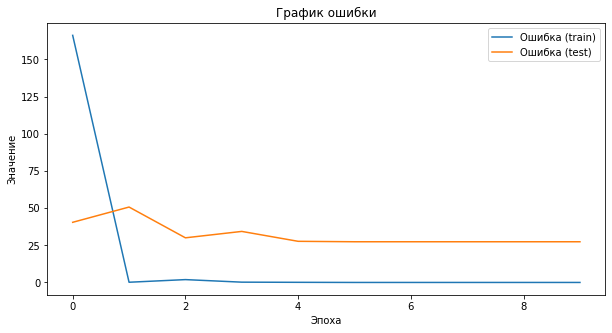

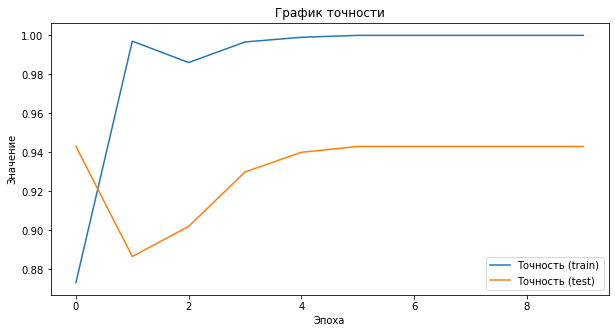

In [17]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [27]:
from keras.models import load_model

# Загружаем контрольную точку (модель)
# Обратите внимание путь до контрольной точки может отличатся
loaded_model = load_model('./save_points_lb5/nn_model_loss-0.00_val_loss-27.36_acc-1.00_val_acc-0.94.hdf5')

# Прдсказываем класс
print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(test)[1]}')

#predict = loaded_model.predict(test)
#predict

157/157 [==============================] - 9s 55ms/step - loss: 0.0000e+00 - acc: 1.0000
Точность предсказания на тренировочных данных 1.0
53/53 [==============================] - 3s 52ms/step - loss: 27.3592 - acc: 0.9430
Точность предсказания на тестовых данных 0.9430267214775085
